<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/book1/supplements/poly_regression_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Polynomial regression in 1d.
Based on sec 4.4 of
 http://d2l.ai/chapter_multilayer-perceptrons/underfit-overfit.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(seed=1)
import math

import torch
from torch import nn
from torch.nn import functional as F

!mkdir figures # for saving plots

!wget https://raw.githubusercontent.com/d2l-ai/d2l-en/master/d2l/torch.py -q -O d2l.py
import d2l


mkdir: cannot create directory ‘figures’: File exists


# Data

Make some data using this function:

**$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).$$**

In [2]:
np.random.seed(42)
max_degree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset sizes
true_w = np.zeros(max_degree)  # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# Convert from NumPy ndarrays to tensors
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

print(true_w)

tensor([ 5.0000,  1.2000, -3.4000,  5.6000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000])


# Train/eval loop

In [4]:
# Incrementally update loss metrics during training

def evaluate_loss(net, data_iter, loss):  #@save
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]


In [9]:
# SGD optimization

def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400, batch_size=50):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(batch_size, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())


# Degree 3 (matches true function)

Train and test loss are similar (no over or underfitting),
Loss is small, since matches true function. Estimated parameters are close to the true ones.



weight: [[ 5.0192533  1.1640984 -3.4049919  5.681488 ]]


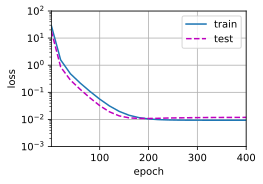

In [6]:

# Pick the first four dimensions, i.e., 1, x, x^2/2!, x^3/3! from the
# polynomial features
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])


# Degree 1 (underfitting)

weight: [[3.440672  3.7903183]]


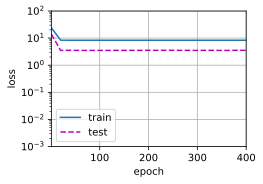

In [7]:
# Pick the first two dimensions, i.e., 1, x, from the polynomial features
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

# Degree 20 (overfitting)

According to the D2L book, the test loss is  higher than training loss.
However, SGD itself has a regularizing effect (even in full batch mode),
so I cannot reproduce overfitting (even though it would occur using a second order optimizer).

weight: [[ 4.93338394e+00  1.32378864e+00 -3.00344729e+00  4.96473312e+00
  -9.01660025e-01  1.74718940e+00  1.18332215e-01  3.38582963e-01
  -1.69122800e-01 -1.72109857e-01  1.05338646e-02 -6.47826344e-02
  -2.10291550e-01  2.04193726e-01  3.11648510e-02  1.30703941e-03
  -1.04185827e-01  5.58913313e-02  1.71128720e-01  1.85162202e-01]]


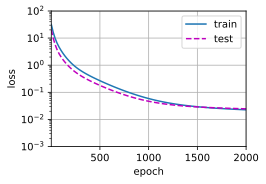

In [11]:
# Pick all the dimensions from the polynomial features
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:],
      num_epochs=2000, batch_size=n_train)